## Ad Tech: Total revenue prediction

The idea of this project is to create a model, that will be able to predict the total revenue value for an ad campaign in order to know the Impact of Digital Advertisement for any Business. The dataset was taken from the Kaggle challenge by the [link](https://www.kaggle.com/datasets/vaishnavkapil/adtech?resource=download).

### Importing the required libraries and downloading the data

In [104]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#### General settings for the notebook

In [105]:
sns.set_palette('Spectral')

#### Getting the data

In [106]:
initial_data = pd.read_csv('data/Ad-Tech.csv')

#### Defining the plotting functions

In [107]:
def plot_cat_counts(data, cat_cols, shape=(2, 2), figsize=(10, 10)):
    fig, ax = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=figsize)
    for i, ax in enumerate(fig.axes):
        ax.ticklabel_format(style='plain', useOffset=False)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
        )

        ax_ = sns.barplot(data[cat_cols[i]].value_counts(), ax=ax)
        max_height = ax.get_ylim()[1]

        for p in ax_.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height+max_height*.01, "{:,}".format(int(height)),
                    ha="center")

        ax.set_title(f'\'{cat_cols[i]}\' distribution')
        ax.tick_params(axis='y', rotation=45)
    plt.show()

def plot_num_dists(data, num_cols, shape=(2, 2), figsize=(10, 10)):
    fig, ax = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=figsize)
    for i, ax in enumerate(fig.axes):
        sns.histplot(data[num_cols[i]], bins=80, kde=True, ax=ax)
        ax.set_title(f'\'{num_cols[i]}\' distribution')
        ax.text(0.80, 0.95,
                f"skew={round(data[num_cols[i]].skew(), 2)}\n"+
                f"kurtosis={round(data[num_cols[i]].kurtosis(), 2)}",
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes)
    plt.show()

def cat_to_q_plot(data, cat_col, num_cols, shape=(2, 4), figsize=(15, 8)):
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(*shape, figure=fig)

    col_idx = 0
    for row in range(shape[0]):
        for col in range(0, shape[1], 2):
            ax1 = plt.subplot(grid[row, col])
            ax2 = plt.subplot(grid[row, col+1])

            sns.histplot(data=data, x=num_cols[col_idx], hue=cat_col, ax=ax1)
            sns.boxplot(data=data, x=num_cols[col_idx], hue=cat_col, ax=ax2)

            col_idx += 1
    plt.show()

def q_to_cat_scatter(data, cat_cols, num_col, shape=(2, 2), figsize=(10, 8)):
    fig, ax = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=figsize)
    for i, ax in enumerate(fig.axes):
        sns.stripplot(data, x=cat_cols[i], y=num_col, ax=ax)
        ax.set_title(f'Division by {cat_cols[i]}')
    plt.show()

def plot_time_series(series, scope=1, title='Time series plot', ylabel='count', figsize=(12, 8)):
    _, ax = plt.subplots(figsize=figsize)
    plt.ylabel(ylabel)
    series[:int(len(series)*scope)].plot(ax=ax)
    ax.set_title(f'{title}')
    plt.show()

### EDA (Exploratory data analysis)

Let's firstly look at the data in general

In [108]:
data = initial_data.copy(deep=True)
data.head(3)

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent
0,30-06-2019 00:00,351,10,187,2,84,3473,19,60,1,4,5174,16,0.0,2,16,1
1,30-06-2019 00:00,351,10,187,2,84,3473,19,58,1,4,5174,6,0.0,0,6,1
2,30-06-2019 00:00,351,10,147,2,84,3473,19,60,1,4,5174,4,0.0,0,4,1


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567291 entries, 0 to 567290
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     567291 non-null  object 
 1   site_id                  567291 non-null  int64  
 2   ad_type_id               567291 non-null  int64  
 3   geo_id                   567291 non-null  int64  
 4   device_category_id       567291 non-null  int64  
 5   advertiser_id            567291 non-null  int64  
 6   order_id                 567291 non-null  int64  
 7   line_item_type_id        567291 non-null  int64  
 8   os_id                    567291 non-null  int64  
 9   integration_type_id      567291 non-null  int64  
 10  monetization_channel_id  567291 non-null  int64  
 11  ad_unit_id               567291 non-null  int64  
 12  total_impressions        567291 non-null  int64  
 13  total_revenue            567291 non-null  float64
 14  view

We can see, that dataset consists of the 567,291 number of samples with 16 features to predict the target, which in this case is total_revenue column. Also it's important to note that this dataset actually doesn't have any missing values, so we can proceed.

The one important thing to do here is to convert the time variable to it's particular dtype which is datetime

In [110]:
data.date = pd.to_datetime(data.date, dayfirst=True)

Now it'd be important to check how many unique values does each variable have

In [111]:
data.describe()

,date,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent
count,567291,567291.000000,567291.000000,567291.000000,567291.000000,567291.000000,567291.000000,567291.000000,567291.000000,567291.0,567291.000000,567291.000000,567291.000000,567291.000000,567291.000000,567291.000000,567291.0
mean,2019-06-15 16:43:33.515814656,347.107775,10.220578,110.226133,1.899669,262.084295,1951.273747,12.632081,57.217194,1.0,14.433716,5136.436645,33.673674,0.069740,12.838251,32.152818,1.0
min,2019-06-01 00:00:00,342.000000,10.000000,1.000000,1.000000,8.000000,45.000000,3.000000,15.000000,1.0,1.000000,5050.000000,0.000000,-0.154200,0.000000,0.000000,1.0
25%,2019-06-08 00:00:00,345.000000,10.000000,39.000000,1.000000,79.000000,45.000000,4.000000,56.000000,1.0,4.000000,5099.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,2019-06-16 00:00:00,346.000000,10.000000,122.000000,2.000000,88.000000,3438.000000,11.000000,57.000000,1.0,19.000000,5127.000000,2.000000,0.000000,0.000000,2.000000,1.0
75%,2019-06-23 00:00:00,350.000000,10.000000,183.000000,3.000000,139.000000,3460.000000,19.000000,58.000000,1.0,19.000000,5168.000000,6.000000,0.005400,2.000000,6.000000,1.0
max,2019-06-30 00:00:00,351.000000,17.000000,308.000000,5.000000,2646.000000,3489.000000,20.000000,60.000000,1.0,21.000000,5443.000000,14452.000000,83.822000,7392.000000,13756.000000,1.0
std,NaN,2.930371,1.222863,66.177820,0.791982,627.325490,1652.545702,6.812571,1.956012,0.0,7.135874,62.508575,220.865448,0.713603,101.989184,207.096504,0.0


From  the describe plot it's not that clear how many unique values do we have, and as we don't have any catcolumns with the object dtype, let's just check it manually.

In [112]:
for col in data.columns:
    print(f'The column \'{col}\' has {data[col].nunique()} unique values.')

The column 'date' has 30 unique values.
The column 'site_id' has 10 unique values.
The column 'ad_type_id' has 2 unique values.
The column 'geo_id' has 219 unique values.
The column 'device_category_id' has 5 unique values.
The column 'advertiser_id' has 23 unique values.
The column 'order_id' has 75 unique values.
The column 'line_item_type_id' has 7 unique values.
The column 'os_id' has 7 unique values.
The column 'integration_type_id' has 1 unique values.
The column 'monetization_channel_id' has 5 unique values.
The column 'ad_unit_id' has 132 unique values.
The column 'total_impressions' has 1979 unique values.
The column 'total_revenue' has 10099 unique values.
The column 'viewable_impressions' has 1159 unique values.
The column 'measurable_impressions' has 1884 unique values.
The column 'revenue_share_percent' has 1 unique values.


From the observation above we can make the following conclusions:
- __Cat columns__: site_id, ad_type_id, device_category_id, line_item_type_id, os_id, monetization_channel_id
- __Cat columns, but with a lot of unique values__: date, geo_id, advertiser_id, order_id, ad_unit_id
- __Quantitive columns__: total_impressions, total_revenue (target), viewable_impressions, measurable_impressions
- __Useless columns (columns that have 1 value)__: integration_type_id, revenue_share_percent

So, based on that, let's create the following lists:

In [113]:
cat_cols = ['site_id', 'ad_type_id', 'device_category_id', 'line_item_type_id', 'os_id', 'monetization_channel_id']
cat_cols_high_dim = ['date', 'geo_id', 'advertiser_id', 'order_id', 'ad_unit_id']
num_cols = ['total_impressions', 'total_revenue', 'viewable_impressions', 'measurable_impressions']
target = 'total_revenue'

Now, let's check the variables' distributions

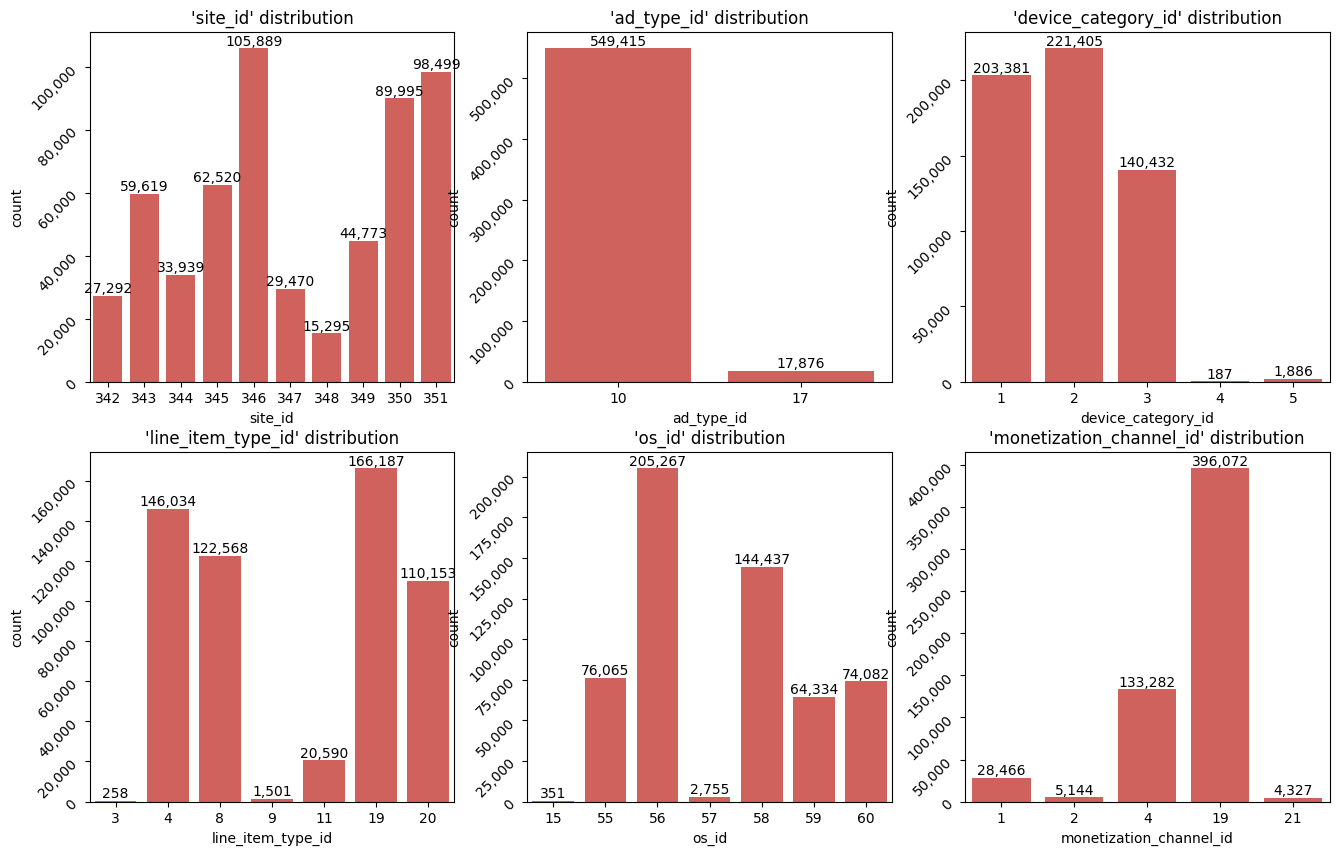

In [29]:
plot_cat_counts(data, cat_cols, shape=(2, 3), figsize=(16, 10))

For some variables we have rare ids, for example:
- For __ad_type__ the id of 10 occurs a lot more than the 17
- For __device_category__ the bigger part of data consists of 1st, 2nd and 3d ids
- For __line_item_type__ the ids of 3, 9 and 11 are rare
- __os_id__ of 15 and 57 are also pretty rare
- The most part of the data has 4 or 19 __monetization_channel__

It makes sense to try to investigate how these variables and their rare values inflict the target.

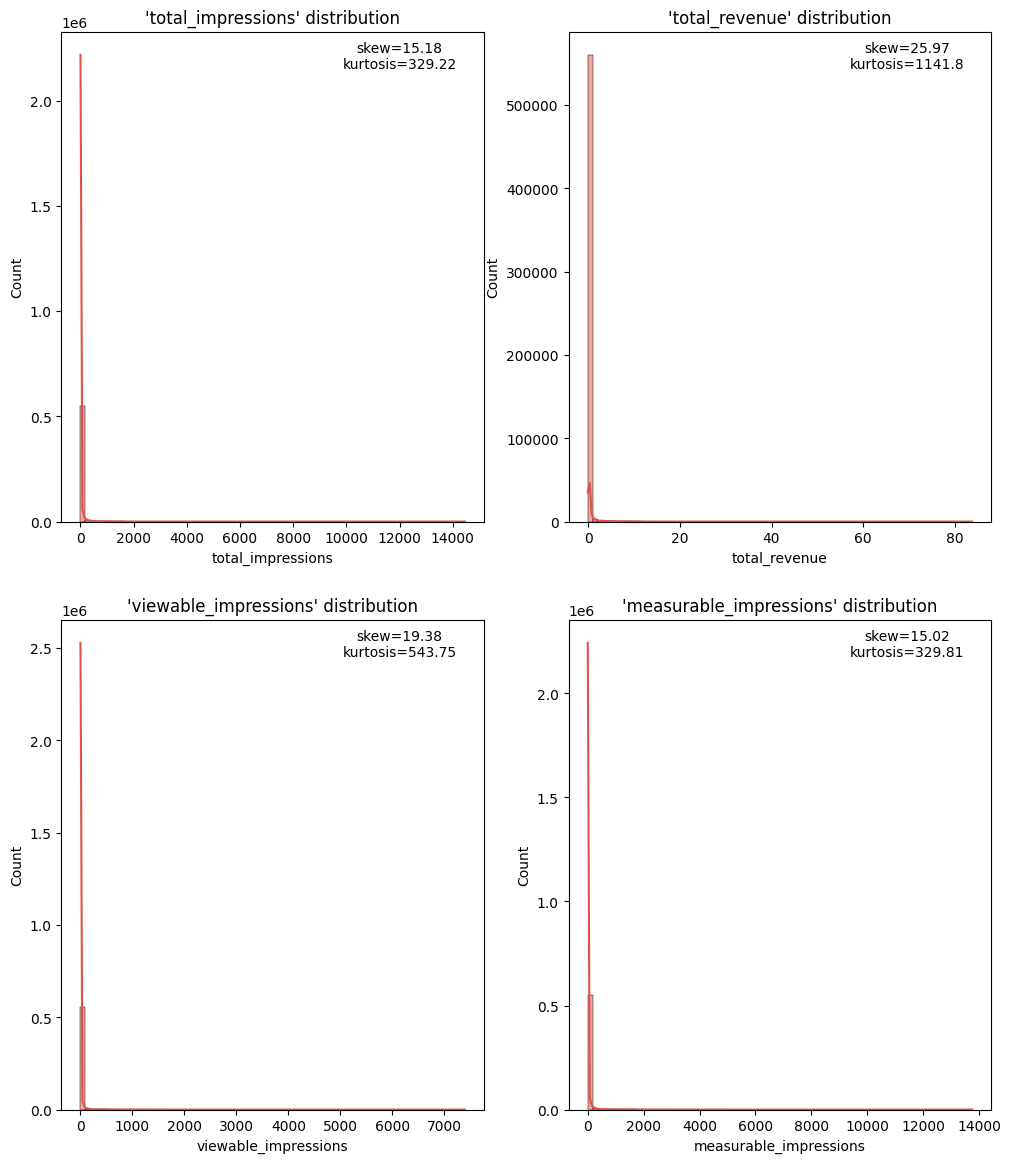

In [31]:
plot_num_dists(data, num_cols, figsize=(12, 14))

All distiributions are skewed because the most amount of samples are near zero

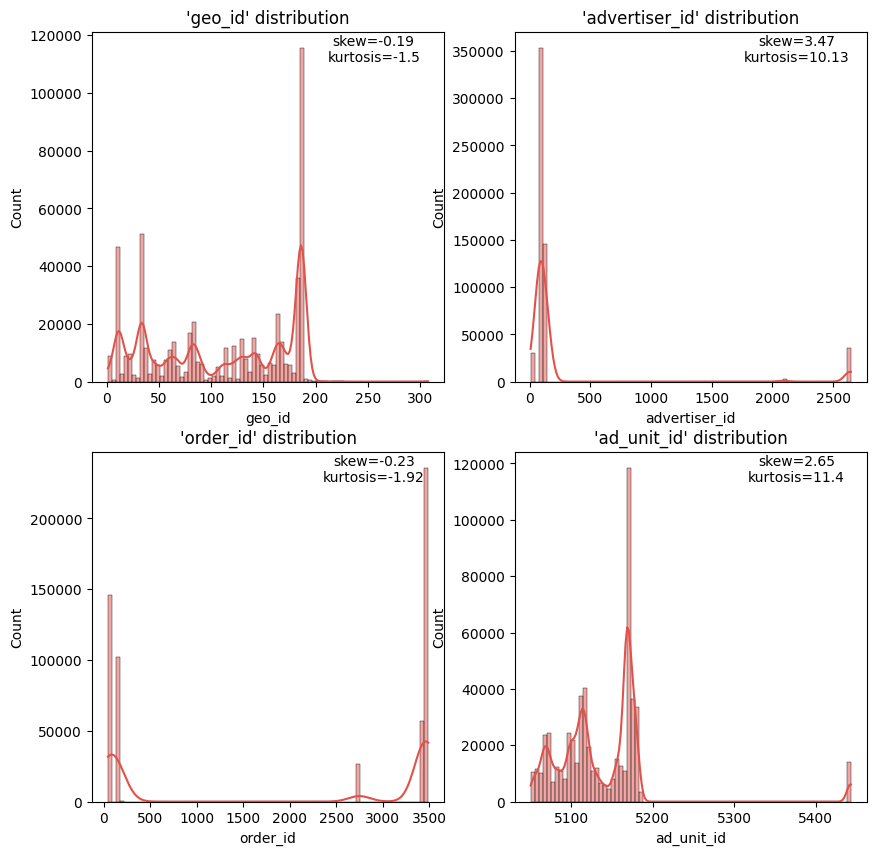

In [32]:
plot_num_dists(data, ['geo_id', 'advertiser_id', 'order_id', 'ad_unit_id'])

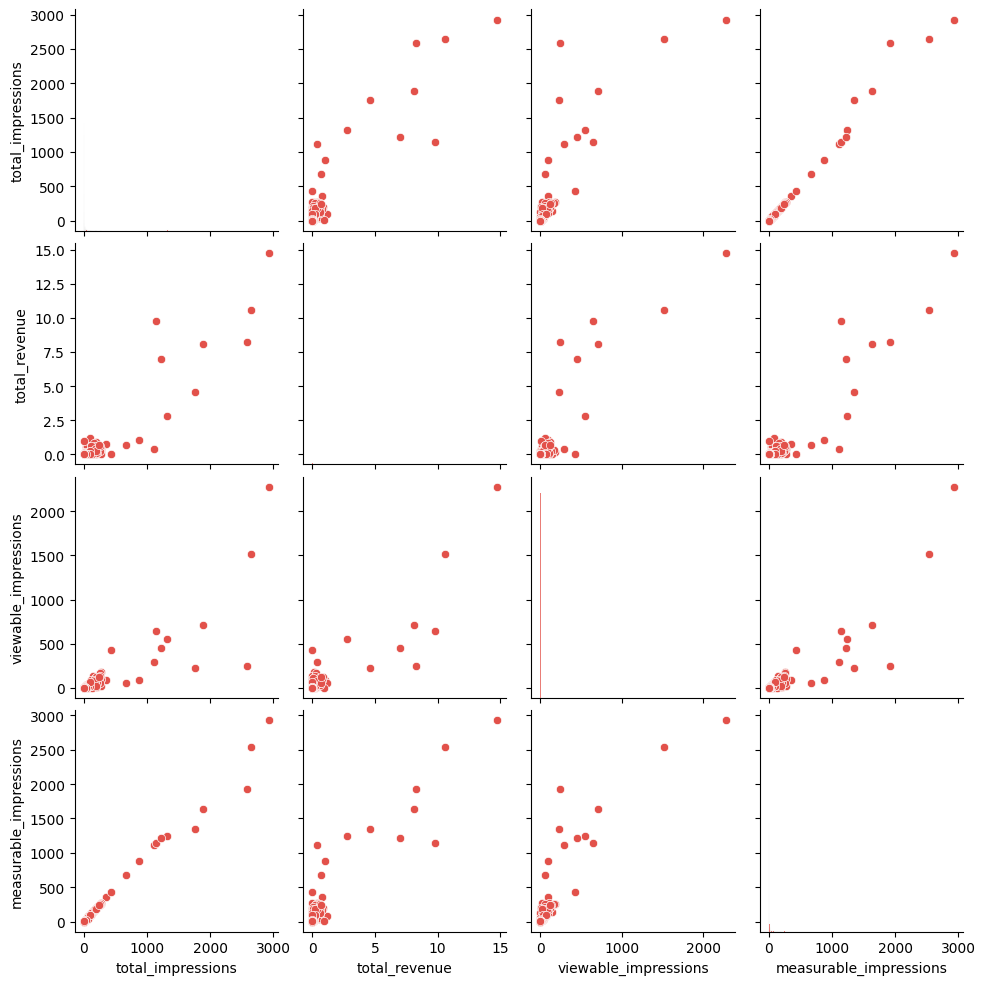

In [37]:
sns.pairplot(data[num_cols].sample(1000))
plt.show()

The dataset has the features that are clearly highly correlated because they caused each other, these features are: total_impressions, viewable_impressions, measurable_impressions and we can also see a high relatioship of the impression variables with the target.

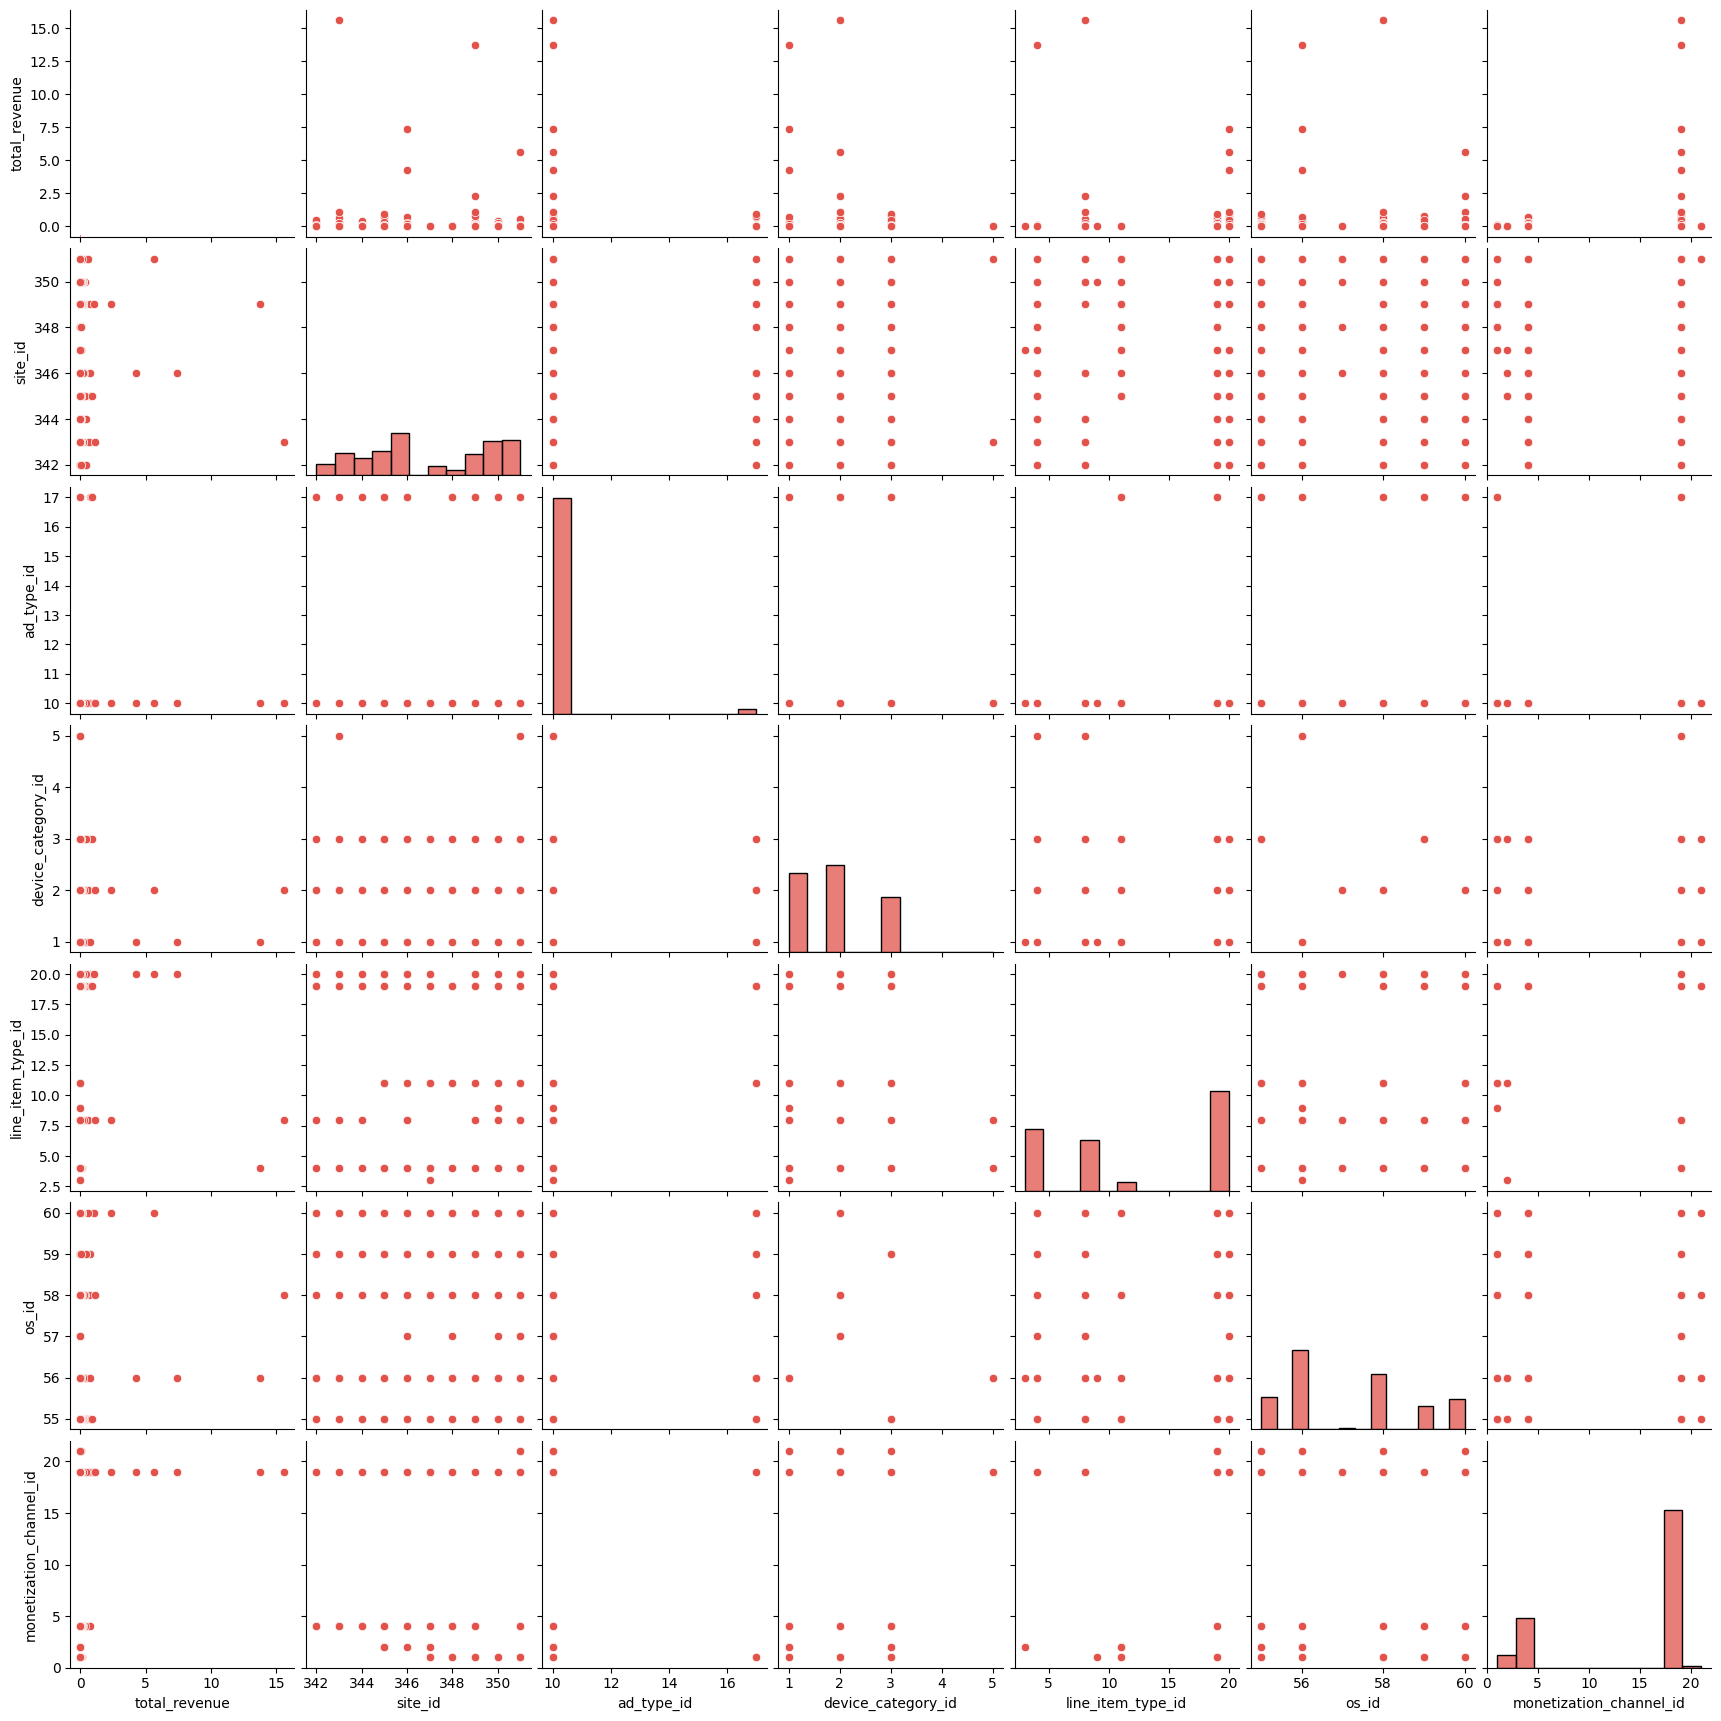

In [40]:
sns.pairplot(data[['total_revenue'] + cat_cols].sample(1000))
plt.show()

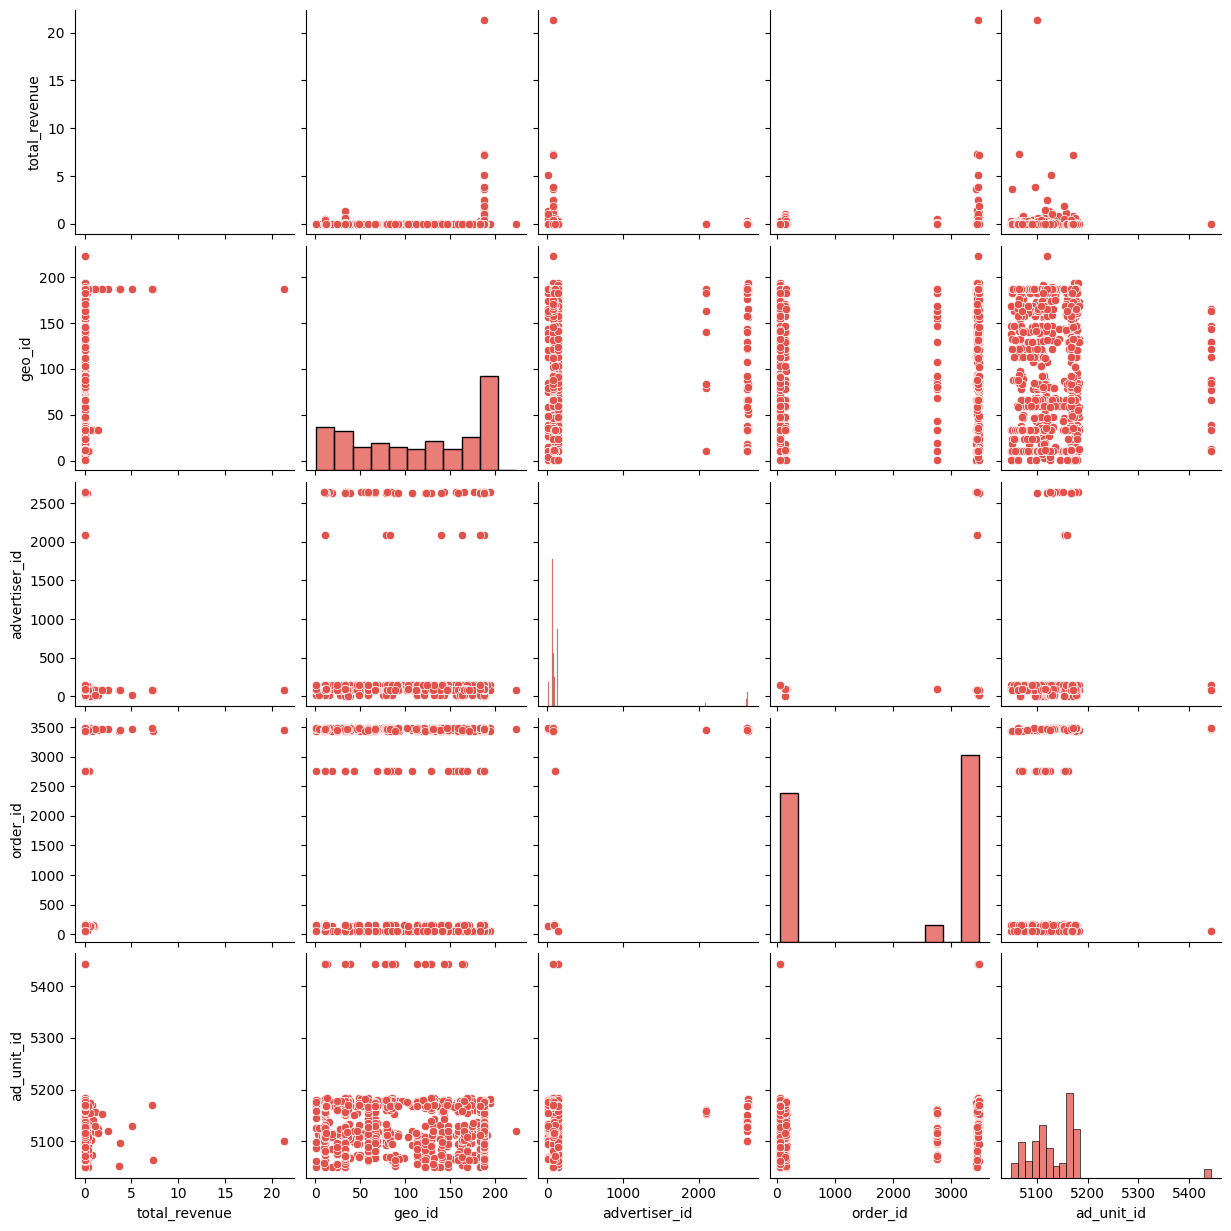

In [42]:
sns.pairplot(data[['total_revenue'] + cat_cols_high_dim].sample(1000))
plt.show()

As we have seen how the numeric features influence the target, let's provide the same analysis for the cat features

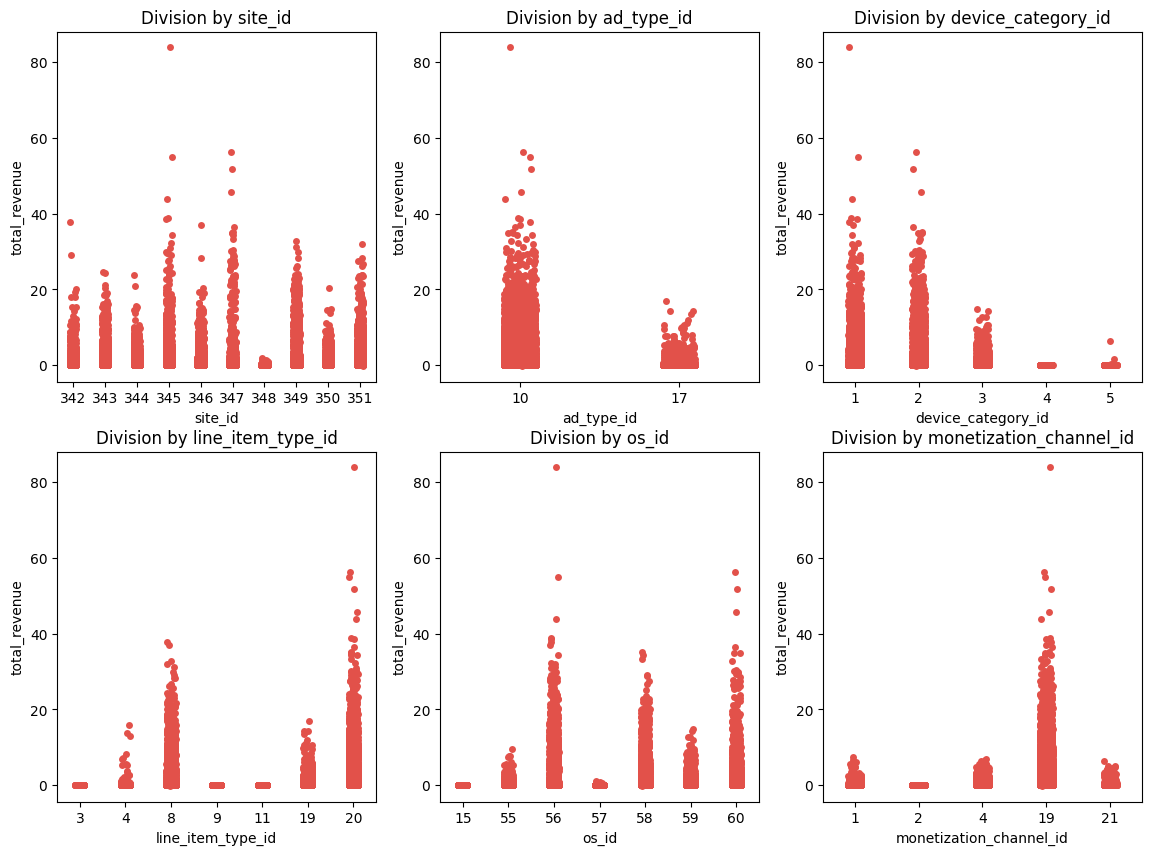

In [116]:
q_to_cat_scatter(data, cat_cols, 'total_revenue', shape=(2, 3), figsize=(14, 10))

We can see, that for some values in some features we have less mean values of total revenue than in the other ones. This works for example for 17 ad type, 4 and 5 device categories, 3, 4, 9 and 11 line item id and so on.

Let's check how these features inflict the target trend lines with the viewable impressions variable

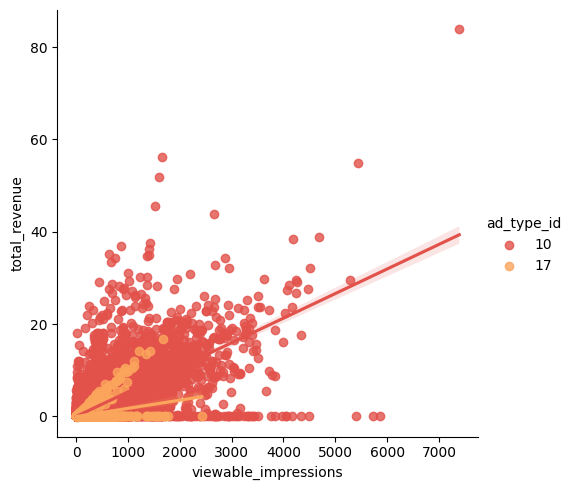

In [119]:
sns.lmplot(data, x='viewable_impressions', y='total_revenue', hue='ad_type_id')
plt.show()

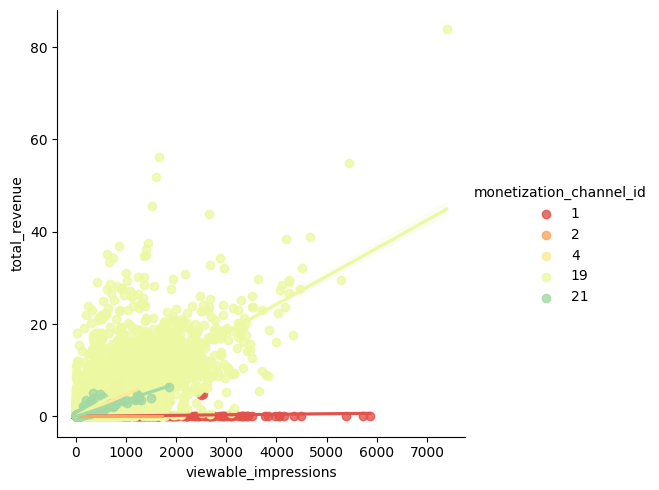

In [120]:
sns.lmplot(data, x='viewable_impressions', y='total_revenue', hue='monetization_channel_id')
plt.show()

From the regplots above it's visible that the we have some differences in trends for a ad_type variable and for monetization_channel_id as well. In case of monetization type id we can see, that for some id's our revenue remains near zero regardless of the counts of viewable impressions

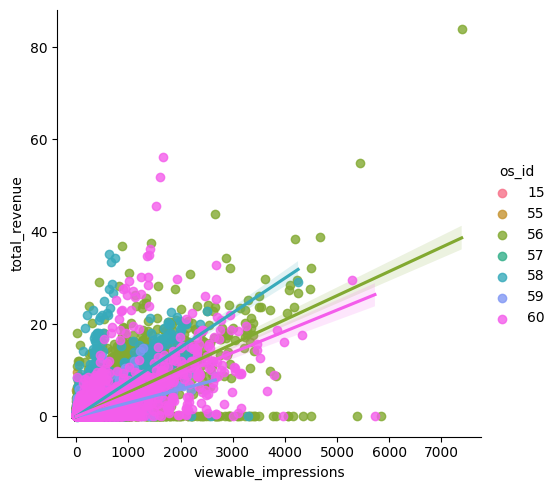

In [14]:
sns.lmplot(data, x='viewable_impressions', y='total_revenue', hue='os_id')
plt.show()

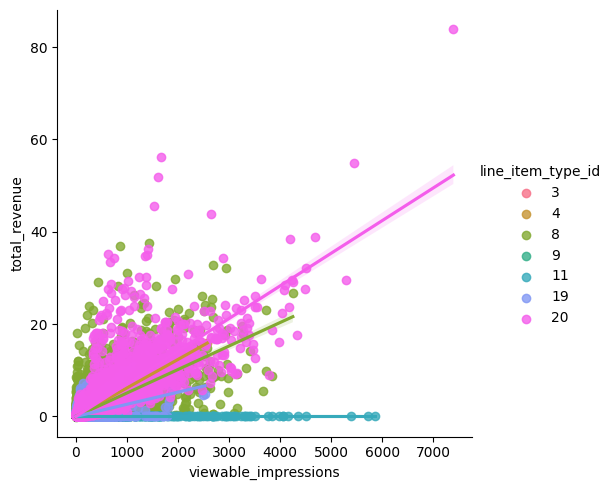

In [16]:
sns.lmplot(data, x='viewable_impressions', y='total_revenue', hue='line_item_type_id')
plt.show()

It can be seen that for os_id variable the trends are not that different from each other, but line_item_type_id has some ids for which the trends are different, for instance we can see that for item type id 19, 9 and 11. The last two actually have the same situation that was for monetization channel id i.e. no matter how many viewable impressions have we got, the total revenue will still be near or equal to zero.

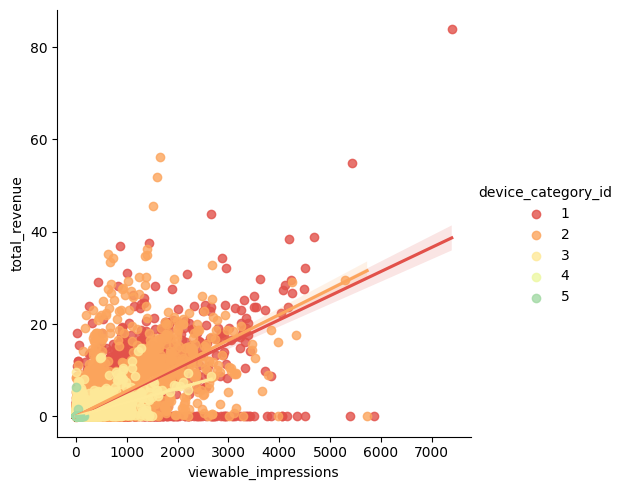

In [19]:
sns.lmplot(data, x='viewable_impressions', y='total_revenue', hue='device_category_id')
plt.show()

For device category we can see some little differnce in trend lines for 3d and 4th ids.

For the site_id variable it'll be hard to plot such tends because of a big amount of labels, so let's to the ANOVA test to try to find some significant difference in the target mean with respect to site_id.

In [114]:
from scipy.stats import f_oneway

list_of_samples = []
for id in data.site_id.unique():
    list_of_samples.append(data[data.site_id == id].total_revenue)

results = f_oneway(*list_of_samples)

In [115]:
p_value = results.pvalue
if p_value > 0.05:
    print(f'Unable to reject the null hypothesis with the p-value of: {p_value}')
else:
    print(f'The p-value is {p_value}, the null hypothesis rejected')

The p-value is 2.7645862411469014e-274, the null hypothesis rejected


As we can see, at least one sample has a significantly different mean from the other ones, which makes a site_id a valuable feature.

Now, let's look at the correlation matrix and see what golden features do we have in the data

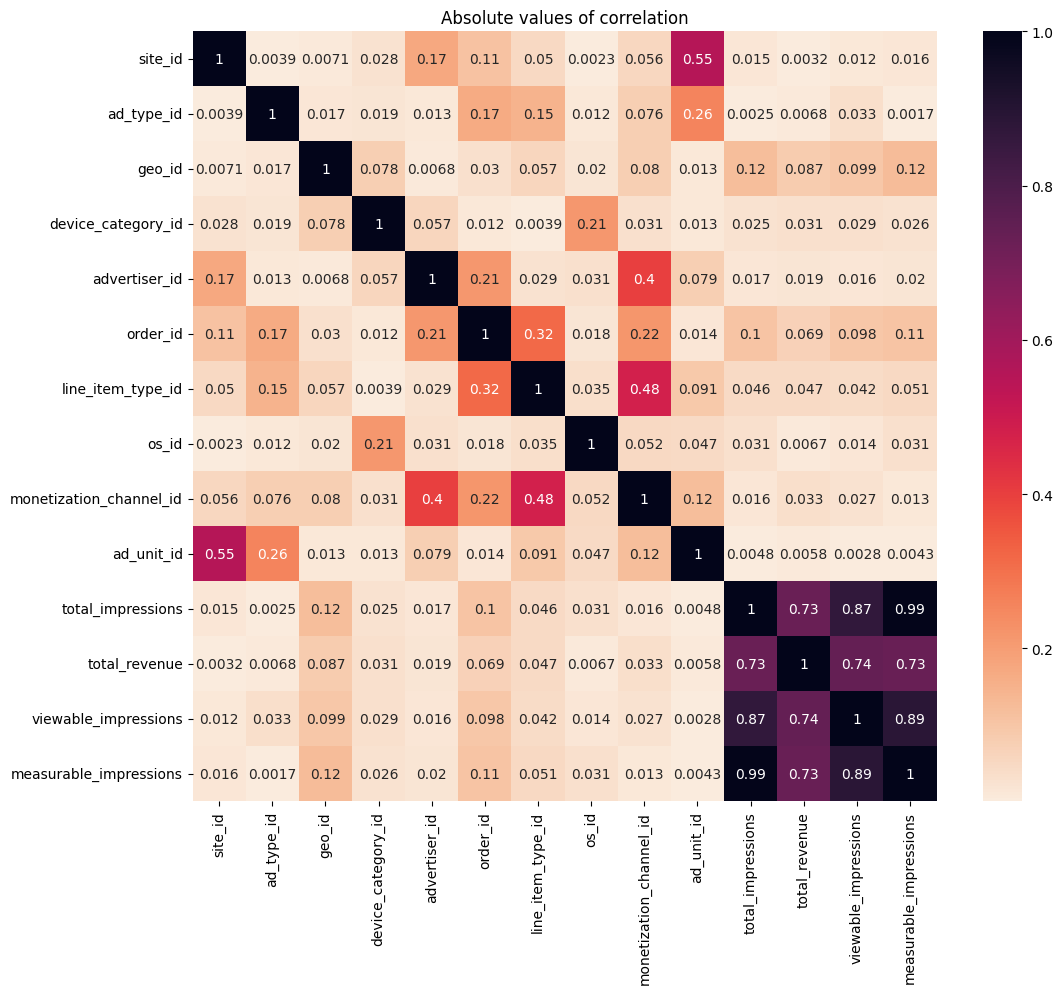

In [20]:
plt.figure(figsize=(12, 10))
plt.title('Absolute values of correlation')
sns.heatmap(np.abs(data.drop(['date', 'integration_type_id', 'revenue_share_percent'], axis=1).corr()), annot=True, cmap='rocket_r')
plt.show()

We have already seen how the numeric and categorical features affect the target, from that research we can conclude that we have some usefull features, that we can keep for the model, these features are:
- total_impressions
- viewable_impressions
- measureable_impressions
- site_id
- ad_type_id
- monetization_channel_id
- os_id
- line_item_id
- device_category

Now, let's investigate the categorical features that have a lot of unique values and try to get some insights from them

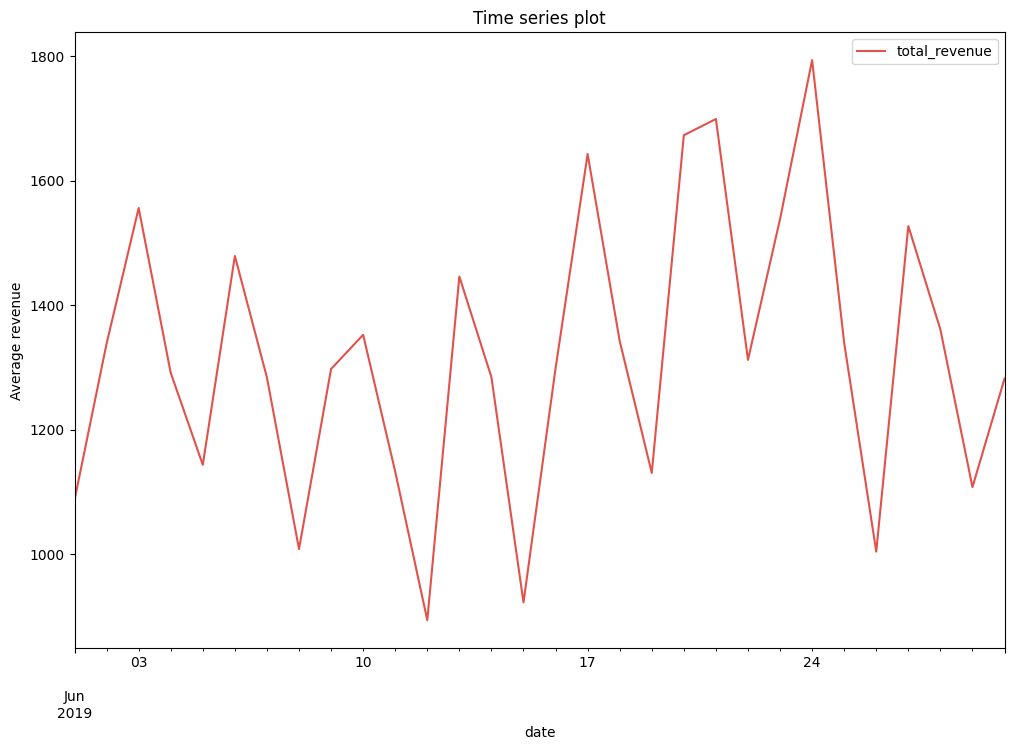

In [14]:
plot_time_series(data[['date', 'total_revenue']].groupby('date').sum(), ylabel='Average revenue')

This plot tells us that we have a less total revenue on each wednesday and saturday. Also we have an increase in total revenue on each sunday.

So, based on that observation I can create a new feature that will represent the day of a week

In [116]:
data['week_day'] = data.date.dt.weekday

In [117]:
data.drop(['date', 'integration_type_id', 'revenue_share_percent'], axis=1, inplace=True)

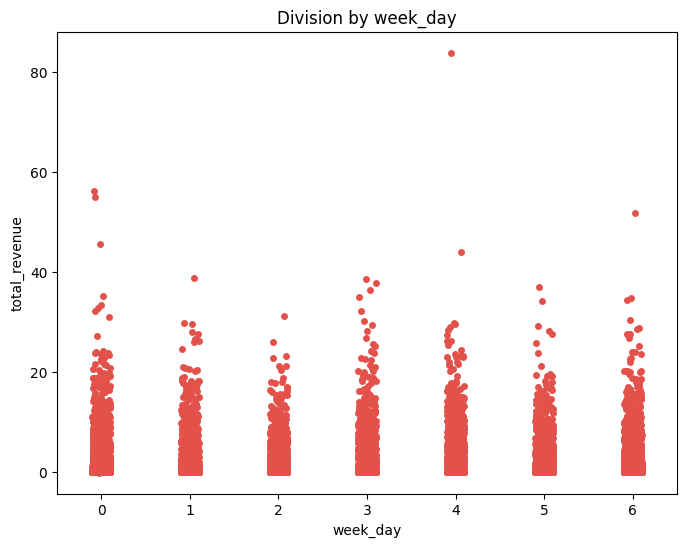

In [17]:
q_to_cat_scatter(data, ['week_day'], 'total_revenue', shape=(1,1), figsize=(8, 6))

And let's also investigate the other cat features with a big amount of unique values

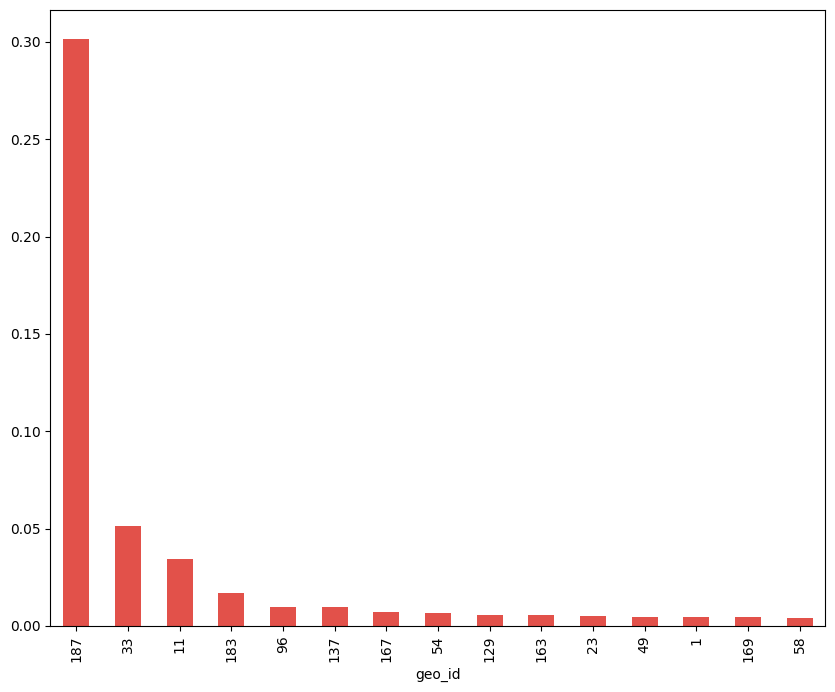

In [38]:
_, ax = plt.subplots(figsize=(10, 8))
geo_total_revenue_data = data.groupby('geo_id')['total_revenue'].mean().sort_values(ascending=False)
geo_total_revenue_data.head(15).plot(kind='bar', ax=ax)
plt.show()

In [118]:
print(f'We have {len(geo_total_revenue_data[geo_total_revenue_data == 0])} regions that have 0 average revenue from the total number of {len(geo_total_revenue_data)}')

We have 7 regions that have 0 average revenue from the total number of 219


In [119]:
print(f'And we have {len(geo_total_revenue_data[geo_total_revenue_data <= 0.05])} regions that have average revenue less than 0.05 from the total number of {len(geo_total_revenue_data)}')

And we have 217 regions that have average revenue less than 0.05 from the total number of 219


The observation above tells us that some regions have extremely higher probability of getting the higher average revenue. Basically we have 3 regions with the highest values for average revenue, these regions are 187, 33 and 11, the rest have pretty similar values near 0. This means that we can create a feature that will represent whether some particular region is one of those or not.

In [178]:
data['profitable_region'] = np.where(data.geo_id == 187, 1, 0)

In [121]:
data.drop(['geo_id'], axis=1, inplace=True)

Now we can provide the same analysis for advertiser, order and ad unit ids:

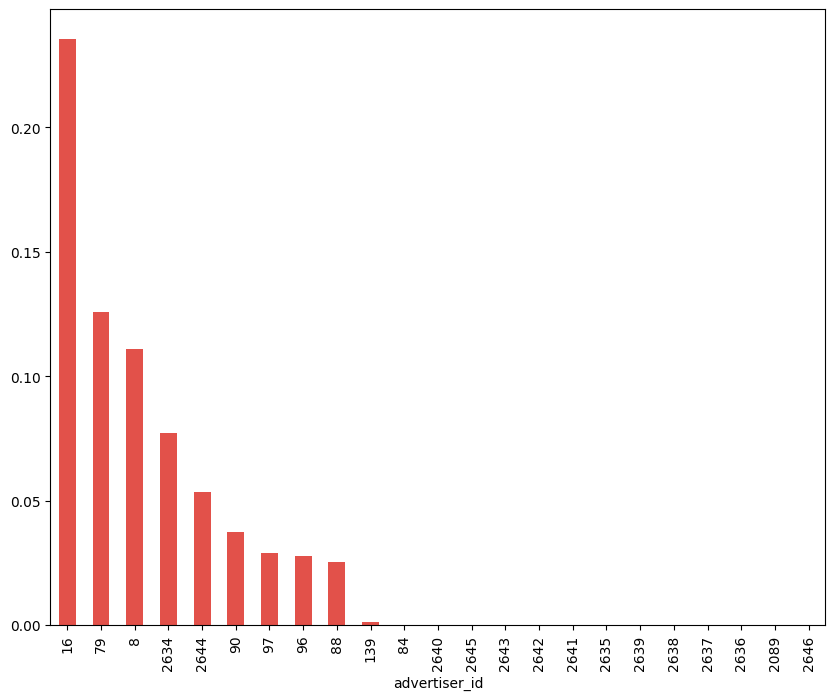

In [51]:
_, ax = plt.subplots(figsize=(10, 8))
advertiser_total_revenue_data = data.groupby('advertiser_id')['total_revenue'].mean().sort_values(ascending=False)
advertiser_total_revenue_data.plot(kind='bar', ax=ax)
plt.show()

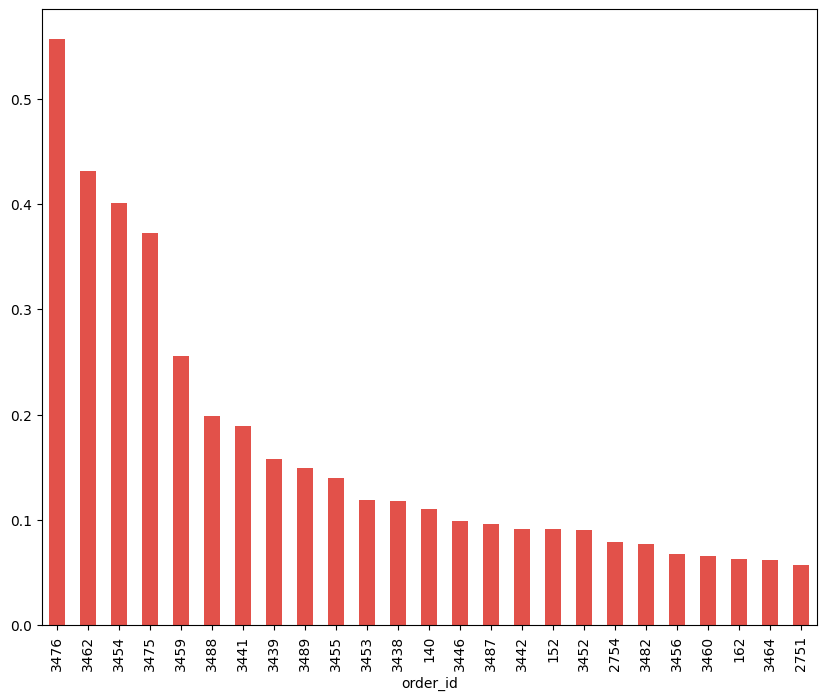

In [53]:
_, ax = plt.subplots(figsize=(10, 8))
order_total_revenue_data = data.groupby('order_id')['total_revenue'].mean().sort_values(ascending=False)
order_total_revenue_data.head(25).plot(kind='bar', ax=ax)
plt.show()

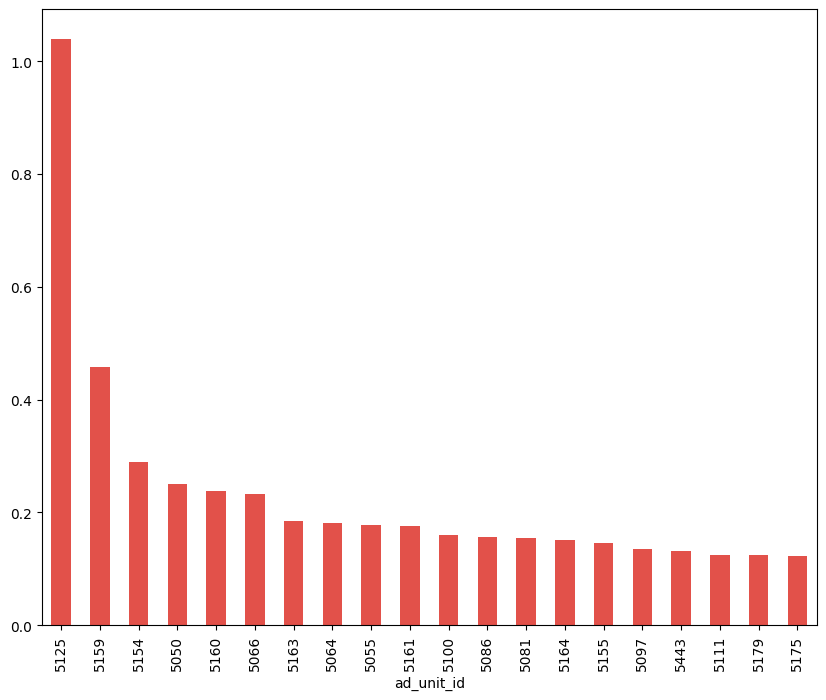

In [55]:
_, ax = plt.subplots(figsize=(10, 8))
ad_unit_total_revenue_data = data.groupby('ad_unit_id')['total_revenue'].mean().sort_values(ascending=False)
ad_unit_total_revenue_data.head(20).plot(kind='bar', ax=ax)
plt.show()

For the advertiser_id, order_id, ad_unit_id we have a little different situation, because they have highly more valuable and profitable ids, so, I think that a good solution would be to provide the target mean encoding with respect to each individual value of that variables. 

### Feature engineering

Let's prepare the columns that we will want to encode

In [122]:
cat_to_encode = cat_cols + cat_cols_high_dim
cat_to_encode.remove('date')
cat_to_encode.remove('geo_id')

In [123]:
all_cols = cat_to_encode + num_cols + ['week_day', 'profitable_region']

In [124]:
data.head(3)

,site_id,ad_type_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,week_day,profitable_region
0,351,10,2,84,3473,19,60,4,5174,16,0.0,2,16,6,1
1,351,10,2,84,3473,19,58,4,5174,6,0.0,0,6,6,1
2,351,10,2,84,3473,19,60,4,5174,4,0.0,0,4,6,0


I also want to create a eCPM (cost per mile) feature that will show the cost per thousand impressions with respect to the add unit and a website it was shown on.

In [157]:
data['eCPM'] = data.groupby(['site_id', 'ad_unit_id'])[['total_impressions', 'total_revenue']].transform('sum').assign(eCPM=lambda x: (x['total_revenue'] / x['total_impressions']) * 1000).eCPM

Let's provide the encoding as well

In [170]:
from sklearn.preprocessing import TargetEncoder

te = TargetEncoder()
data[cat_to_encode] = te.fit_transform(data[cat_to_encode], data.total_revenue)

Let's check the finall correlations with the target to understand what features have the higher impact on it

In [179]:
data.corr()['total_revenue'].sort_values(ascending=False, key=lambda x: abs(x))

total_revenue              1.000000
viewable_impressions       0.742076
measurable_impressions     0.732053
total_impressions          0.730177
profitable_region          0.162416
order_id                   0.135668
ad_unit_id                 0.115466
line_item_type_id          0.093033
advertiser_id              0.089111
eCPM                       0.084474
site_id                    0.047633
os_id                      0.034950
monetization_channel_id    0.033961
device_category_id         0.032083
ad_type_id                 0.006710
week_day                  -0.000671
Name: total_revenue, dtype: float64

## Playground with Geotile

In [3]:
from geotile import GeoTile

gt = GeoTile('land_shallow_topo_2048.tif')

c:\Users\artur.shamrai@sigma.software\OneDrive - Sigma Software LLC\Tasks\Task_2\venv\lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [5]:
gt.generate_tiles(tile_x=256, tile_y=256)